# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from torchtext import data
import re
# custom path
os.chdir('../..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def flatten_category(labelled_data):
    """ convert multiple labels to multiple rows """
    data = []
    for i, row in tqdm(labelled_data.iterrows(), desc='rows'):
        for t,w in row['category'].items():
            row['topic'] = t
            row['weight'] = w
            data.append(row)
    data = pd.DataFrame(data)
    return data

## Data prep

In [2]:
DATA = 'data/interim/train_data.csv'

### Load

In [16]:
data = pd.read_csv(DATA,)
data['description'].fillna("", inplace=True)
data['category'] = data['category'].apply(eval)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32999 entries, 0 to 32998
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         32999 non-null  object 
 1   description   32999 non-null  object 
 2   recent_posts  32999 non-null  object 
 3   lang_code     32999 non-null  object 
 4   id            967 non-null    float64
 5   category      32999 non-null  object 
 6   subset        32999 non-null  object 
 7   text          32999 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.0+ MB


### Flatten categories

In [17]:
data_flat = flatten_category(data,)

data_flat.shape

(68332, 10)

### Topic distribution

In [21]:
from src.train.plot_utils import barplots

ru


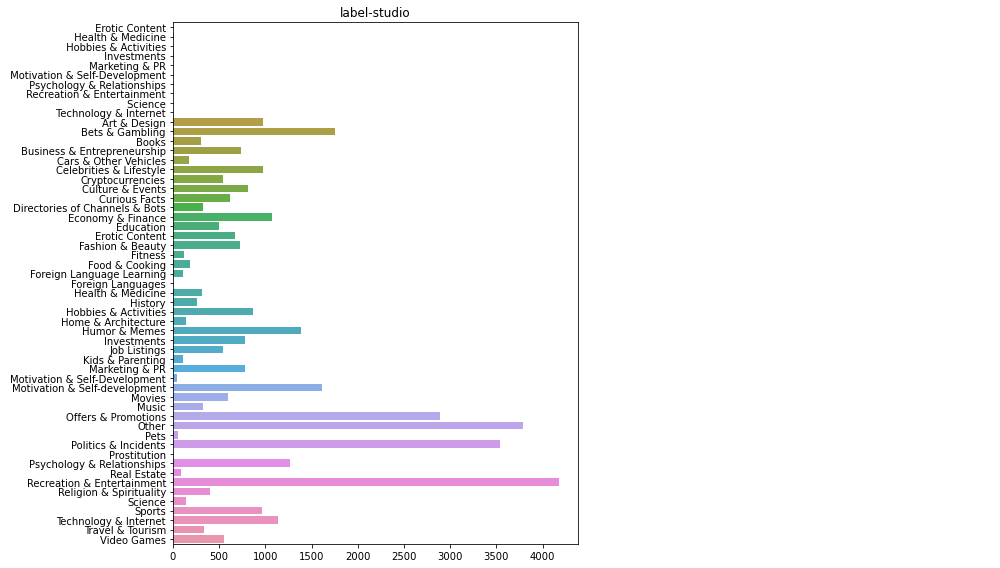

en


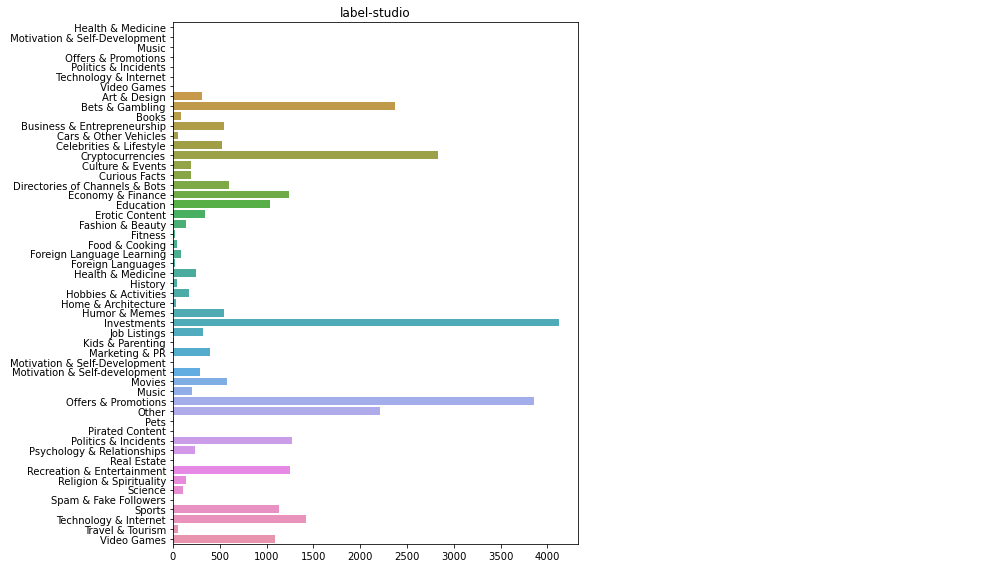

fa


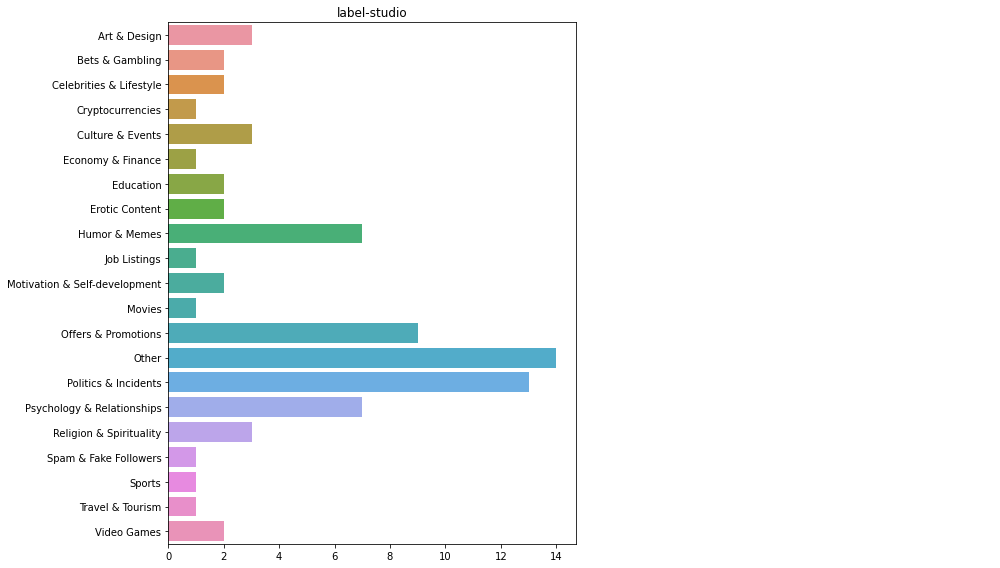

uz


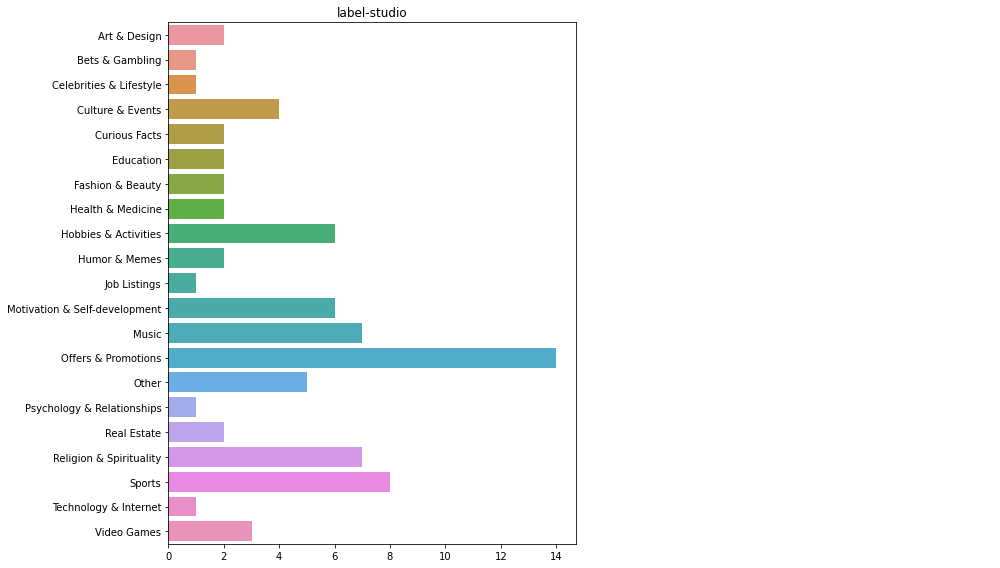

ar


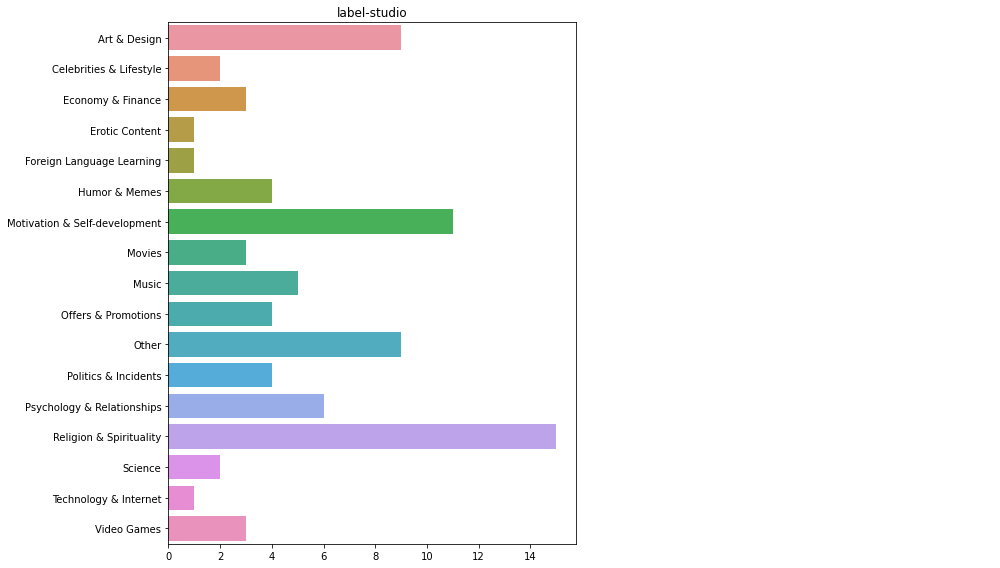

In [22]:
for l in data_flat['lang_code'].unique():
    print(l)
    barplots({
        'label-studio': data_flat.query(f"lang_code == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8))

In [23]:
print('Unique topics per language')
print(data_flat.groupby('lang_code')['topic'].nunique())

Unique topics per language
lang_code
ar    17
en    53
fa    21
ru    55
uz    21
Name: topic, dtype: int64


### Load stopwords

In [24]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
}

In [25]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

420

## Experiments

**Improve:**
- [ ] cross-val
- [x] weighted metric

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.
- [ ] datasets {tg, r-1, r-2}
- [ ] ngrams, chars vs words

In [26]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [27]:
from src.train.text_utils import tokenize_text

In [39]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, lang_code, preprocessing, vect, est):
        self.LANG = lang_code
        self.data = data_flat.query(f"lang_code == '{lang_code}'")
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(lang_code)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        # text inputs and 
#         inputs['text'] = inputs.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
#         test_data['text'] = test_data.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        # split into  train and test
#         test_subset = test_data.query(f"lang_code == '{self.LANG}'")
#         external_subset = inputs.query(f"lang_code == '{self.LANG}'")
        self.train_inputs,self.test_inputs = train_test_split(self.data, test_size=TEST_SIZE, random_state=24, shuffle=True,)
#         comb_datasets = [external_subset, one, self.test_inputs] if is_final else [external_subset, one]
#         self.train_inputs = pd.concat(one, axis=0)
        # x and y
        self.y_train = self.train_inputs['topic']
        self.y_test = self.test_inputs['topic']
        self.sample_weights = self.train_inputs['weight']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        try:
            self.clf.fit(self.X_train, self.y_train, sample_weight=self.sample_weights)
        except TypeError as e:
            logging.warning(e.args[0])
            self.clf.fit(self.X_train, self.y_train)
#         self.predictions = pd.DataFrame({
#                     'true': trainer.test_inputs['topics'],
#                     'predicted': trainer.clf.predict_proba(trainer.X_test)
#                 })
        predicted = trainer.clf.predict_proba(trainer.X_test)
        scores = score_predictions(trainer.test_inputs['category'], predicted, self.clf.classes_)
        return np.mean(scores)
    

def calc_weight_score(topic_weights, predicted_probs, classes):
    true_weights = np.zeros(len(classes))
    for t,w in topic_weights.items():
        index = np.argwhere(classes == t).squeeze()
        true_weights[index] = w
    mae = round(sum(abs(true_weights - predicted_probs)),4)
    return 1 / (1 + mae)


def score_predictions(true_topics, predicted_probs, classes):
    scores = list(map(lambda x: calc_weight_score(x[0],x[1],classes),
                         zip(true_topics, predicted_probs)))
    return scores

### Set hyper-parameters

In [40]:
TEST_SIZE = 0.1

In [41]:
PREPROCESSING = [
    'raw',
#     'lemma',
]

vect_params = dict(
    max_df=0.4, 
    min_df=3,
    max_features=1000,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
#     'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
#     mnb = MultinomialNB(),
)

In [42]:

train_params = list(itertools.product(data_flat['lang_code'].unique(), 
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

5

### Run experiments

In [43]:
results = []

for params in tqdm_notebook(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['lang_code','preprocessing','vect', 'est', 'score'])

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# experiments:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [44]:
for l in results['lang_code'].unique():
    print(results.query(f'lang_code == "{l}"').sort_values('score', ascending=False).to_markdown(), end='\n\n')

|    | lang_code   | preprocessing   | vect   | est   |    score |
|---:|:------------|:----------------|:-------|:------|---------:|
|  0 | ru          | raw             | tfidf  | cnb   | 0.351742 |

|    | lang_code   | preprocessing   | vect   | est   |    score |
|---:|:------------|:----------------|:-------|:------|---------:|
|  1 | en          | raw             | tfidf  | cnb   | 0.352982 |

|    | lang_code   | preprocessing   | vect   | est   |    score |
|---:|:------------|:----------------|:-------|:------|---------:|
|  2 | fa          | raw             | tfidf  | cnb   | 0.385731 |

|    | lang_code   | preprocessing   | vect   | est   |    score |
|---:|:------------|:----------------|:-------|:------|---------:|
|  3 | uz          | raw             | tfidf  | cnb   | 0.439835 |

|    | lang_code   | preprocessing   | vect   | est   |   score |
|---:|:------------|:----------------|:-------|:------|--------:|
|  4 | ar          | raw             | tfidf  | cnb   | 0.37

In [59]:
calc_weight_score({'a': 0.01, 'b': 0.0021, 'c':0.0019}, np.array([0.5,0.2,0.01]), np.array(list('abc')))

0.589622641509434

### Review errors

#### Train

In [33]:
trainer = Trainer(
    lang_code = 'en', 
    preprocessing = 'raw',
    vect = 'tfidf', 
    est = 'cnb'
)
s = trainer.run_eval(final=False)
print(s)

0.3886376133335339


#### Classification report

In [34]:
test_pred = trainer.clf.predict_proba(trainer.X_test)

# is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs.copy()

errors['score'] = score_predictions(errors['topics'], test_pred, trainer.clf.classes_)

#### random examples

In [35]:
def get_top_classes(probs, classes):
    top_inds = np.argwhere(probs > probs.mean()).squeeze(1)
    return {classes[i]:probs[i] for i in top_inds}

In [36]:
i = random.randint(0, len(errors)-1)
row = errors.iloc[i]
pred = get_top_classes(test_pred[i], trainer.clf.classes_)

# print('PREDICTED:\n', row['predicted'], end='\n\n')
print('MAE:\n', row['score'], end='\n\n')
print('TRUE:\n', row['topics'], end='\n\n')
print('PREDICTED:\n', pred, end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
# print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
# print('DESCRIPTION:\n', row['description'], end='\n\n')

MAE:
 0.36791758646063283

TRUE:
 {'Cryptocurrencies': 0.5, 'Offers & Promotions': 0.5}

PREDICTED:
 {'Celebrities & Lifestyle': 0.05300547675082715, 'Cryptocurrencies': 0.05412033059280983, 'Movies': 0.054194690225672304, 'Offers & Promotions': 0.0868930579909177}

TEXTS:
 IMcrypto || NEWS
~ ICO/IEO
~ CRYPTO TRAIDING EVENT
~ CRYPTO AIRDROP
~ BOUNTY
~ AMA 
🌏WEBSITE : imcryptoworld.com
ENGLISH grup : t.me/imcryptoGlobal
Email busnies : imcryptoworld@gmail.com
Twitter : https://twitter.com/

📲Contact :@abaycs
+628568935713
​​​​​​🚀 Vera Protocol Airdrop
🎁 Get $5 Vera +2/reff
🔘 ETH Network
Good project partner with matic

🔻Start bot here
🔹join telegram
🔹Follow twitter & retweet
🔹Enter ERC20 Address

Max 50 reff

😎 HAPPY EARNINGS
🔔New Airdrop Polka Domain $NAME
▫️Registration: 11th to 15th of April
▫️200000 $NAME tokens will be airdropped: 
▫️25% to .eth ENS owners and 75% to random participants who perform few simple tasks (link below)
▫️You will get your tokens 17th of April 
Details: htt

#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [37]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [38]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb':
            if probs.std(0) < 0.0001:
                return {"Other": 1.0}
        else:
            if probs.max() < 0.1:
                return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [39]:
V = 'tfidf'
E = 'cnb'
L = 'en'

trainer = Trainer(
    lang_code = L, 
    preprocessing = 'raw',
    vect = V, 
    est = E,
)
_ = trainer.run_eval(final=False)

tgcat = TgCat(TextVectorizer(V, trainer.vect), NaiveBayes(E, trainer.clf), top_k=3)

In [40]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [41]:
v = tgcat.vect(batch)
p = tgcat.clf(v)

In [42]:
tgcat([['a','s','d'], [""], ["other", 'other', 'ttt'], ["чгк", "нияег", "его"]])

[{'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}]

In [43]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'Other': 0.4076470040912342, 'Technology & Internet': 0.334597442131186, 'Sports': 0.25775555377757986}

TOKENS ['𝙑𝙞𝙘𝙚𝙆𝙞𝙞𝙙𝙍𝙎𝘼', '𝙁𝙧𝙚𝙚𝙣𝙚𝙩', '𝙒𝙤𝙧𝙡𝙙', '𝙃𝙚𝙧𝙚', '𝙔𝙤𝙪', '𝘾𝙖𝙣', '𝙂𝙚𝙩', '𝙀𝙝𝙞', '𝙉𝙫𝙥', '𝙉𝙡𝙭', '𝙄𝙫𝙧𝙖𝙮', '𝙃𝙖𝙩', '𝙃𝙘', '𝘿𝙖𝙩', '𝙏𝙧𝙞𝙘𝙠𝙨', '𝘼𝙞𝙧𝙩𝙞𝙢𝙚', '𝙏𝙧𝙞𝙘𝙠𝙨', '𝙑𝙋𝙉', '𝙁𝙖𝙨𝙩', '𝙞𝙣𝙩𝙚𝙧𝙣𝙚𝙩', '𝙏𝙧𝙞𝙘𝙠𝙨', '𝘼𝙘𝙘𝙤𝙪𝙣𝙩𝙨', '𝚔𝚗𝚘𝚠', '𝚝𝚑𝚎', '𝚛𝚞𝚕𝚎𝚜𝙰𝚏𝚝𝚎𝚛', '𝚖𝚒𝚗𝙽𝙾', '𝙿𝙰𝚂𝚂', '𝙼𝙰𝙳𝙴', '𝙴𝚂𝙿𝙴𝙲𝙸𝙰𝙻𝙻𝚈', '𝙵𝙾𝚁', '𝙼𝚈', '𝚂𝚄𝙱𝚂', '𝙴𝙽𝙹𝙾𝚈', '𝙰𝙽𝙳', '𝙵𝙴𝙴𝙳𝙱𝙰𝙲𝙺', '𝙾𝙽', '𝙲𝙾𝙼𝙼𝙴𝙽𝚃', '𝙿𝙻𝙴𝙰𝚂𝙴', '𝐀𝐋𝐋', '𝐁𝐄', '𝐃𝐑𝐎𝐏𝐏𝐄𝐃', '𝐉𝐎𝐈𝐍', '𝐍𝐎𝐖', '𝐇𝐄𝐑𝐄', 'vgienet', 'vgienet', 'vgienet', '𝐏𝐑𝐈𝐍𝐂𝐄', '𝐕𝐆𝐈𝐄𝐘', 'hello', 'welcome', 'to', 'anonymous', 'just', 'gonna', 'provide', 'you', 'the', 'best', 'hacking', 'gang', 'channelthey', 'send', 'hacking', 'tools', 'for', 'android', 'how', 'to', 'hack', 'social', 'media', 'tools', 'mobiles', 'hacker', 'internet', 'hacker', 'mtn', 'vodaco', 'telko', 'cell', 'data', 'free', 'tricks', 'are', 'shared', 'hereplease', 'help', 'us', 'by', 'subscribing', 'to', 'our', 'channel', 'anonymousst', 'anonymousst'

### Final training, convert and save

In [44]:
from sklearn.preprocessing import normalize

In [45]:
prediction_params = {
    'top_k': 3
}

In [46]:
for l in results['lang_code'].unique():
    subset = results.query(f"lang_code == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    print(l, 'best', best_params)
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect), )
    tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    src_vects = trainer.X_test.toarray()
    assert np.allclose(src_vects, vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru best {'lang_code': 'ru', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.3881145815598802}
ru 0.3881145815598802
saved to models/trained/tgcat/ru_tgcat.pt
en best {'lang_code': 'en', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.3886376133335339}
en 0.3886376133335339
saved to models/trained/tgcat/en_tgcat.pt
fa best {'lang_code': 'fa', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.38573138413243047}
fa 0.38573138413243047
saved to models/trained/tgcat/fa_tgcat.pt
uz best {'lang_code': 'uz', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.4398347391994336}
uz 0.4398347391994336
saved to models/trained/tgcat/uz_tgcat.pt
ar best {'lang_code': 'ar', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.37513961342068}
ar 0.37513961342068
saved to models/trained/tgcat/ar_tgcat.pt


### Check file sizes

In [47]:
!du -hm models/trained/*/* | sort -nr

17	models/trained/embed/ru_bow_script.pt
17	models/trained/embed/en_bow_script.pt
10	models/trained/tgcat/ru_tgcat.pt
9	models/trained/tgcat/uz_tgcat.pt
9	models/trained/tgcat/fa_tgcat.pt
9	models/trained/tgcat/en_tgcat.pt
9	models/trained/tgcat/ar_tgcat.pt
9	models/trained/embed/uz_tfidf_script.pt
9	models/trained/embed/ru_tfidf_script.pt
9	models/trained/embed/fa_tfidf_script.pt
9	models/trained/embed/en_tfidf_script.pt
9	models/trained/embed/ar_tfidf_script.pt
1	models/trained/embed/ru_bow.txt
1	models/trained/classify/uz_cnb_script.pt
1	models/trained/classify/ru_mnb_script.pt
1	models/trained/classify/ru_cnb_script.pt
1	models/trained/classify/fa_mnb_script.pt
1	models/trained/classify/fa_cnb_script.pt
1	models/trained/classify/en_cnb_script.pt
1	models/trained/classify/ar_cnb_script.pt
